In [1]:
import torch
from torch import nn
from torchvision import datasets, models, transforms
import pretrainedmodels
import numpy as np
import PIL
import os
from matplotlib import cm

In [2]:
# Define the class for loading Inception v4 network.
# The class is spetial tuned for only outputing the feature map predicted by the network.
class ConvnetModel(nn.Module):
    def __init__(self):
        super(ConvnetModel, self).__init__()
        self.convnet = pretrainedmodels.models.inceptionv4()
        kernel_count = self.convnet.last_linear.in_features
        self.convnet.last_linear = nn.Linear(kernel_count, 1)

    def forward(self, x):
        x = self.convnet.features(x)
        return x

In [3]:
# Operations for loading data sets.

DATA_MEAN = 0.20558404267255
DATA_STD = 0.17694948680626902473216631207703

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(360, resample=PIL.Image.BICUBIC, expand=False, center=None),
        transforms.ColorJitter(brightness=0.05, contrast=0, saturation=0, hue=0),
        transforms.RandomResizedCrop(299, scale=(0.8, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([DATA_MEAN, DATA_MEAN, DATA_MEAN], [DATA_STD, DATA_STD, DATA_STD])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((350, 350)),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([DATA_MEAN, DATA_MEAN, DATA_MEAN], [DATA_STD, DATA_STD, DATA_STD])
    ]),
}

data_dir = 'MURA_Torch_Format'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

In [14]:
# Given the network and input tensor, return the image with diagnostic location.
# Input_tensor should have shape (1, 3, 299, 299)

def locate(net, input_tensor):
    
    # Calculate weighted sum of all feature map.
    fc_weight = net.convnet.last_linear.weight.detach().numpy()
    feature_map = net(input_tensor)
    feature_map_np = feature_map.detach().numpy()
    weighted_feature_map = fc_weight.reshape((1, 1536, 1, 1)) * feature_map_np[0]
    sumed_feature_map = np.sum(weighted_feature_map[0], axis=0)
    
    # Normalize weight-sumed feature map and convert it to 8-bit gray scale.
    sumed_feature_map -= np.min(sumed_feature_map)
    sumed_feature_map /= np.max(sumed_feature_map)
    sumed_feature_map *= 255
    sumed_feature_map = np.around(sumed_feature_map)
    sumed_feature_map = sumed_feature_map.astype(np.uint8)
    
    # Scale feature map to (299, 299) with bluring.
    scaled_feature_map = PIL.Image.fromarray(sumed_feature_map)
    gaussian = PIL.ImageFilter.GaussianBlur()
    scaled_feature_map = scaled_feature_map.resize((32, 32))
    scaled_feature_map = scaled_feature_map.filter(gaussian)
    scaled_feature_map = scaled_feature_map.resize((64, 64))
    scaled_feature_map = scaled_feature_map.filter(gaussian)
    scaled_feature_map = scaled_feature_map.resize((128, 128))
    scaled_feature_map = scaled_feature_map.filter(gaussian)
    scaled_feature_map = scaled_feature_map.resize((299, 299))
    scaled_feature_map = scaled_feature_map.filter(gaussian)
    
    # Build heatmap from feature map
    gray_feature_map = np.asarray(scaled_feature_map)
    colormap = cm.get_cmap('inferno') # or what ever color map you want
    heatmap = colormap(gray_feature_map)
    heatmap = np.delete(heatmap, 3, axis=2)
    
    # Transfer input tensor back to image.
    DATA_MEAN = 0.20558404267255
    DATA_STD = 0.17694948680626902473216631207703
    input_array = input_tensor.detach().numpy()[0]
    input_array = input_array * DATA_STD + DATA_MEAN
    input_array = input_array.transpose(1, 2, 0)
    
    # Apply masked merge between heatmap and input.
    mask = np.asarray(scaled_feature_map)
    mask = mask / 255
    mask = mask.reshape(299, 299, 1)
    result_array = input_array * (1 - mask) + heatmap * mask
    result_array *= 255
    result_array = np.around(result_array)
    result_array = np.clip(result_array, 0, 255)
    result_array = result_array.astype(np.uint8)
    result_image = PIL.Image.fromarray(result_array)
    
    return result_image

In [9]:
# Load parameters from file

net = ConvnetModel()
model_checkpoint = torch.load("m-20180518-024519-A.pth.tar")
net.load_state_dict(model_checkpoint['state_dict'])

In [30]:
# Test case
# Input_tensor should have shape (1, 3, 299, 299)
input_sample = next(iter(dataloaders['train']))[0][8:9]
output_sample = locate(net, input_sample)

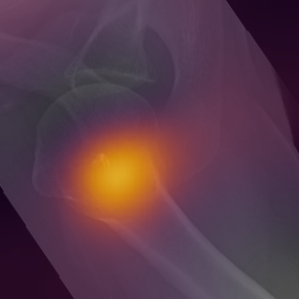

In [31]:
output_sample